In [53]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'street_address', 'has_pool', 'has_garage', 'number_of_garage_spaces', 'number_of_stories', 'lot_size_in_square_feet',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                'year_built': 'Year Built'})
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64') #For numerical analysis: Use int or float if there are missing values
Atlanta_Distance

,current_listing_price,listing_date,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,2865,3/12/2024,2002,4,3259.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,2200,3/2/2024,<NA>,3,1993.0,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,2000,2/15/2024,<NA>,3,1910.0,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1995,3/17/2024,<NA>,3,1134.0,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,2800,3/3/2024,<NA>,4,2532.0,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...
21010,1600,3/9/2023,<NA>,3,1367.0,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
21011,2199,3/4/2024,<NA>,3,1696.0,2009.36,6142.54,888.22,4864.86,1477.04,2.5
21012,2380,3/16/2024,2015,3,1944.0,1507.23,714.63,1158.08,1359.41,3952.51,3.5
21013,1900,3/4/2024,<NA>,4,1204.0,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [54]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = Atlanta_Distance.select_dtypes(include=['object']).columns

In [55]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [56]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [57]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,5.031097e-01,0.641662,1.314310,-0.636824,0.541928,-0.543506,-0.853198,-0.558318,0.177326
1,-1.091762e-14,-0.459475,0.111774,1.494518,-1.156558,-0.087041,-1.210471,-0.973399,-0.475680
2,-1.091762e-14,-0.459475,0.032935,1.155358,0.069832,0.144052,3.139891,-0.400516,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,-0.822093,-0.038145,-0.327959,0.075214,-0.663046,-1.781691
4,-1.091762e-14,0.641662,0.623754,-0.262428,0.631150,0.740791,0.741912,3.104812,-0.475680
...,...,...,...,...,...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,2.915148,0.542839,-0.400154,2.169024,0.161205,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,-1.506863,0.467361,-0.791183,-0.447233,-0.951263,0.177326
21012,1.127320e+00,-0.459475,0.065230,-1.555905,-1.068952,-0.703911,-1.059161,-0.165986,1.483337
21013,-1.091762e-14,0.641662,-0.637674,2.265398,-0.874252,1.760934,0.586626,-1.025782,-0.475680


In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
xgb_model = XGBRegressor(random_state=42)
# Define the full model pipeline including the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

#1. Split the dataset into a train set and a test set.
#2. Split the training data further into a training set and a validation set.
#3. Use the validation set for tuning, then assess performance on the test set.

X = Atlanta_Distance.drop(columns='current_listing_price')
y = Atlanta_Distance['current_listing_price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #This splits your data into 80% (X_train_val) and 20% (X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) #X_train_val data is further split into 60% train set (X_train) and 20% validation (X_val)
#Note: the test_size=0.25 is used to split the remaining training and validation set into 75% training and 25% validation (75% of 80% = 60%)
pipeline.fit(X_train, y_train) #The pipeline is fit on the training data and evaluated on the validation set (X_val)


#Test Set (X_test): This set is a held-out portion of the data that the model has never seen during training or tuning, making it the best indicator of the model's generalization performance. The test score tells you how well the model is likely to perform on truly unseen data, which is typically the main goal.

#Validation Set (X_val): The validation set is primarily used during model selection and hyperparameter tuning. It gives a good intermediate measure of model performance, but since it has influenced model tuning, it can no longer be considered a truly unbiased assessment of generalization.

#Combined Train-Validation Set (X_train_val): This set is used for final training once the best model has been selected. While scores on this set give an idea of how well the model fits on a larger amount of data, they do not represent true generalization performance, as the data has been used for model tuning and training.

#Training Set (X_train): The training set score can help diagnose underfitting or overfitting during development, but it isn’t relevant as a final evaluation metric because it doesn’t measure how well the model generalizes.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [59]:
val_score = pipeline.score(X_val, y_val) #0.6137914878103629
print('Validation R^2:', val_score)

test_score = pipeline.score(X_test, y_test) #0.55202185736604
print('Test R^2:', test_score)

Validation R^2: 0.5828114042195607
Test R^2: 0.5887373264613718


In [60]:
from sklearn.metrics import mean_squared_error #average squared difference between predicted and actual values
#When comparing different models, 
#the one with the lowest MSE on the validation or test set is generally considered to be the better model for predicting the target variable.

#Low RMSE values show that the model makes more accurate predictions and fits the data well
y_val_pred = pipeline.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 348029.3331461368
Validation Root Mean Squared Error: 589.9401097960172
Test Mean Squared Error: 351261.6801554851
Test Root Mean Squared Error: 592.6733334270111


In [61]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 15.140242970201923
Test Mean Absolute Percentage Error (MAPE): 15.269312336827937


In [62]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'regressor__n_estimators': [400],
    'regressor__learning_rate': [0.05],
    'regressor__max_depth': [10],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__alpha': [1],
    'regressor__lambda': [1]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=10,  # Cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2
)

grid_search.fit(X_train, y_train)
# Print the best hyperparameters found by the grid search
print("Best hyperparameters:", grid_search.best_params_)

print("Best cross-validation score (R2):", grid_search.best_score_)

val_score_tuned = grid_search.best_estimator_.score(X_val, y_val)
print("Validation R^2 with best model: ", val_score_tuned)

# Final test set evaluation
test_score_tuned = grid_search.best_estimator_.score(X_test, y_test)
print("Test R^2 with best model: ", test_score_tuned)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best hyperparameters: {'regressor__alpha': 1, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 1, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 10, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best cross-validation score (R2): 0.6144806488068555
Validation R^2 with best model:  0.6297537511302045
Test R^2 with best model:  0.6234107297799412


In [63]:
y_val_pred_tuned = grid_search.best_estimator_.predict(X_val)
val_mse_tuned = mean_squared_error(y_val, y_val_pred_tuned) 
print("Validation Mean Squared Error with best model: ", val_mse_tuned)
val_rmse_tuned = np.sqrt(val_mse_tuned)
print("Validation Root Mean Squared Error with best model: ", val_rmse_tuned)


y_test_pred_tuned = grid_search.best_estimator_.predict(X_test)
test_mse_tuned = mean_squared_error(y_test, y_test_pred_tuned) 
print("Test Mean Squared Error with best model: ", test_mse_tuned)
test_rmse_tuned = np.sqrt(test_mse_tuned)
print("Test Root Mean Squared Error with best model:", test_rmse_tuned)

Validation Mean Squared Error with best model:  308868.83389743714
Validation Root Mean Squared Error with best model:  555.7596907813999
Test Mean Squared Error with best model:  321646.9383127745
Test Root Mean Squared Error with best model: 567.1392583067889


In [64]:
val_mape_tuned = calculate_mape(y_val, y_val_pred_tuned)
test_mape_tuned = calculate_mape(y_test, y_test_pred_tuned)
print("Validation MAPE with best model:", val_mape_tuned)
print("Test MAPE with best model:", test_mape_tuned)

Validation MAPE with best model: 13.735941617347514
Test MAPE with best model: 13.923119039802732


In [65]:
best_xgb_model = grid_search.best_estimator_.named_steps['regressor']
feature_importances = best_xgb_model.feature_importances_

In [66]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

In [67]:
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.3459
Feature: Living Area(SQF), Importance: 0.1655
Feature: Total Bedrooms, Importance: 0.0846
Feature: Wholesale, Importance: 0.0802
Feature: Supercenter, Importance: 0.0755
Feature: Convenience, Importance: 0.0729
Feature: Supermarket, Importance: 0.0695
Feature: Year Built, Importance: 0.0573
Feature: Variety Store, Importance: 0.0487


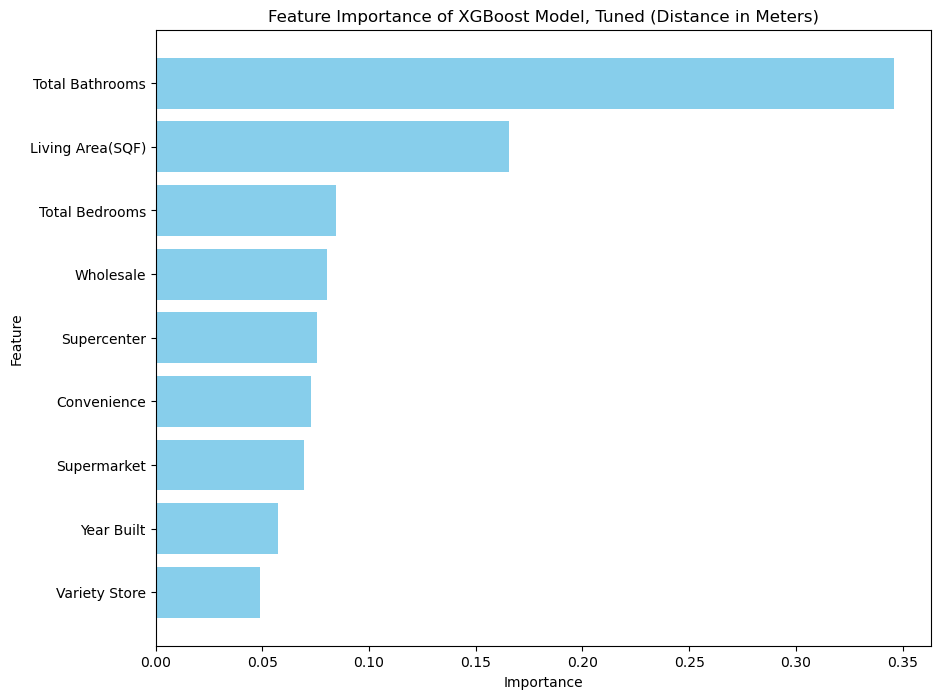

In [68]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [400],
    'regressor__learning_rate': [0.05],
    'regressor__max_depth': [10],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__alpha': [1],
    'regressor__lambda': [1]
}

# Multi-scoring in GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],  # Multiple scoring
    refit='r2',  # Specify which metric to refit
    cv=10,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Access the results
results = grid_search.cv_results_
print("Best parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)


mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 1, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 1, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 10, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best R^2: 0.6144806488068555
Mean MSE scores: [316337.16781953]
Mean MAPE scores: [0.13926515]
Mean R^2 scores: [0.61448065]
Mean RMSE scores: [561.39120041]


In [70]:
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mse, mape, rmse

In [71]:
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")
#Refitted model may be causing data leakage, and therefore different results. Differences can be ignored

Tuned Validation Set Scores:
R²: 0.6298
MSE: 308868.8339
MAPE: 0.1374
RMSE: 555.7597

Tuned Test Set Scores:
R²: 0.6234
MSE: 321646.9383
MAPE: 0.1392
RMSE: 567.1393

Tuned Train-Val Set Scores:
R²: 0.8989
MSE: 83363.0487
MAPE: 0.0571
RMSE: 288.7266


In [72]:
best_xgb_model = best_model.named_steps['regressor']
feature_importances = best_xgb_model.feature_importances_

In [73]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

In [74]:
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.3459
Feature: Living Area(SQF), Importance: 0.1655
Feature: Total Bedrooms, Importance: 0.0846
Feature: Wholesale, Importance: 0.0802
Feature: Supercenter, Importance: 0.0755
Feature: Convenience, Importance: 0.0729
Feature: Supermarket, Importance: 0.0695
Feature: Year Built, Importance: 0.0573
Feature: Variety Store, Importance: 0.0487


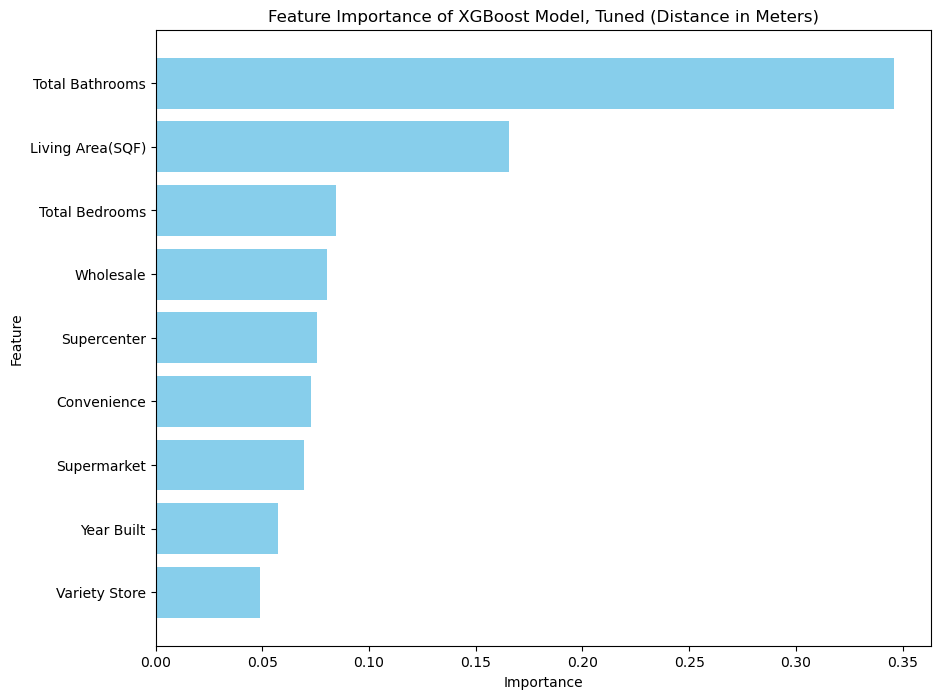

In [75]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [76]:
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

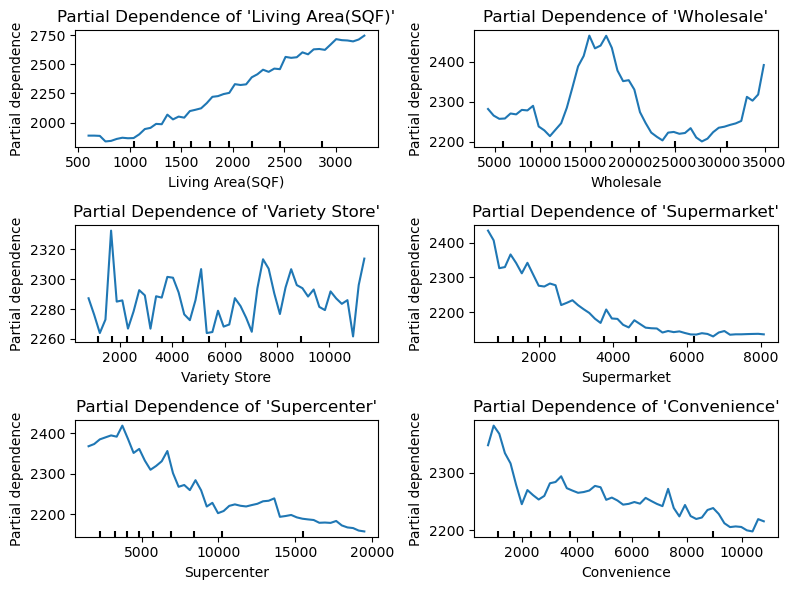

In [77]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# List of features to include in the Partial Dependence Plots
features = [
    'Living Area(SQF)', 'Wholesale', 'Variety Store', 'Supermarket', 
    'Supercenter', 'Convenience',
]

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 2  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_val,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]  # Place in the correct subplot
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

ValueError: Feature 'Garage Spaces' not in feature_names

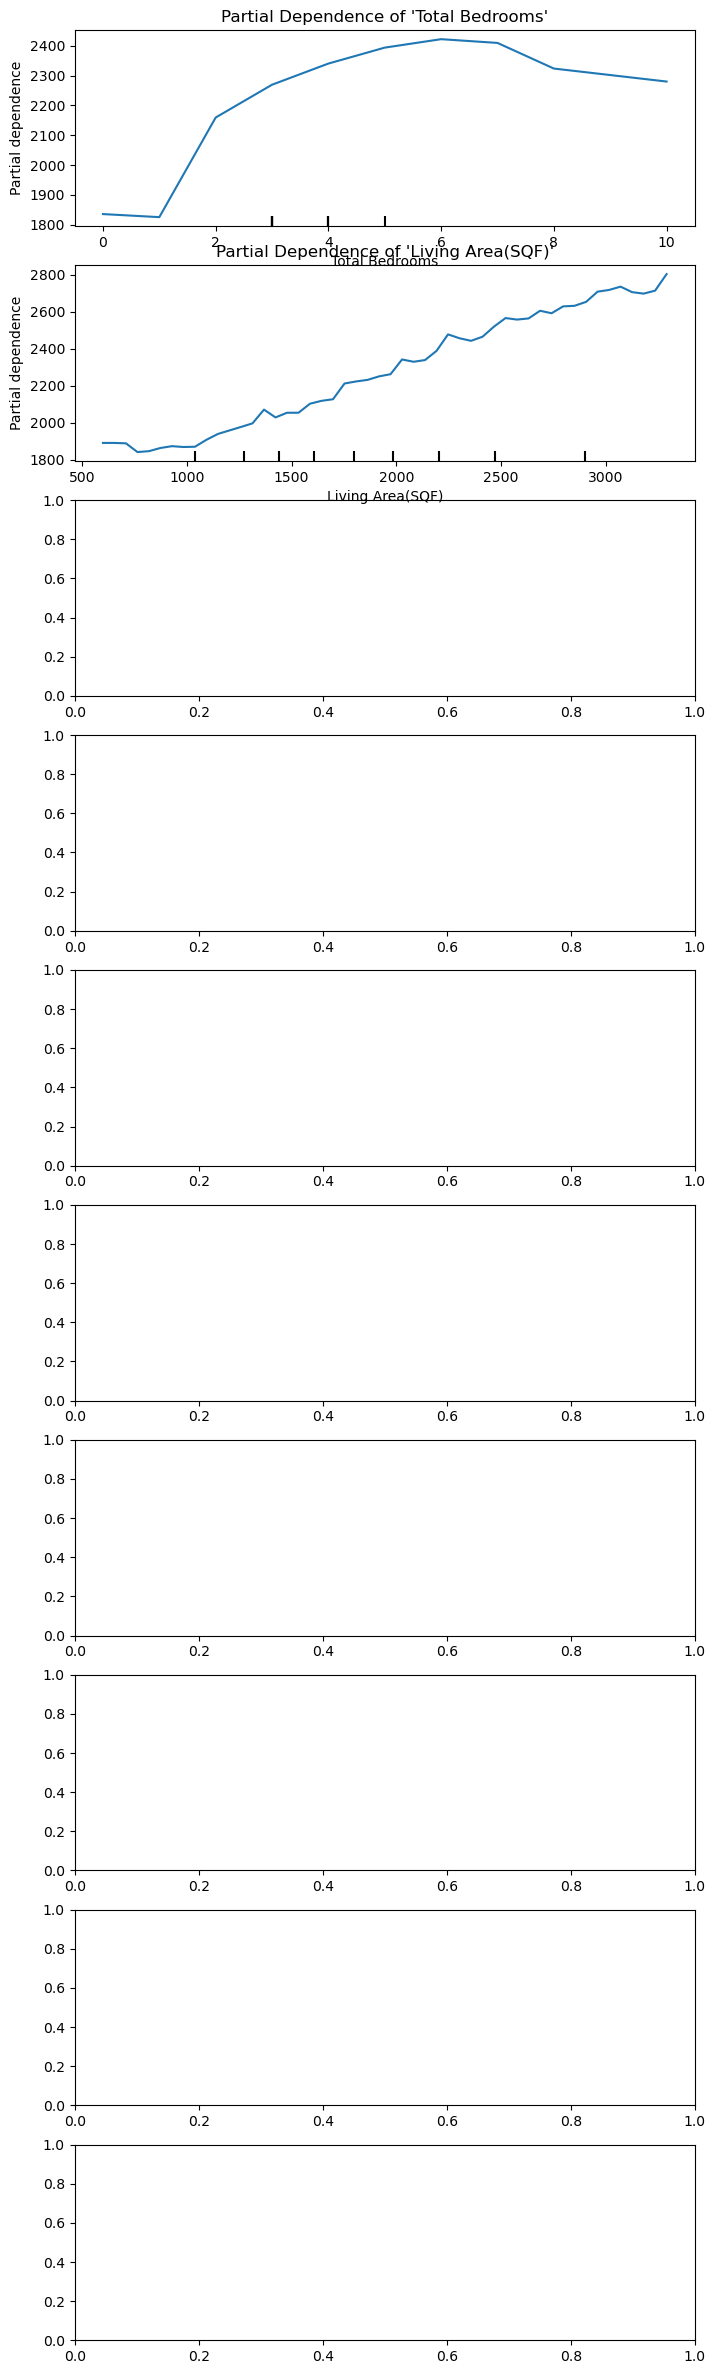

In [78]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of features to include in the Partial Dependence Plots
features = [
    'Total Bedrooms', 'Living Area(SQF)', 'Garage Spaces', 
    'Stories', 'Wholesale', 'Variety Store', 'Supermarket', 
    'Supercenter', 'Convenience', 'Total Bathrooms'
]

# Create partial dependence plots for each feature
fig, axes = plt.subplots(nrows=len(features), figsize=(8, len(features) * 3))

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_val, 
        [feature],
        grid_resolution=50,
        ax=axes[i] if len(features) > 1 else axes  # Handle subplot based on number of features
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()